In [38]:
from torchvision import datasets, transforms
import torch

# 데이터 세트
train_ds = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_ds  = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

# 데이터 로더
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

In [39]:
# 데이터 로더에서 이미지를 1장만 로딩합니다.
images, labels = next(iter(train_dl))
images.shape

torch.Size([64, 1, 28, 28])

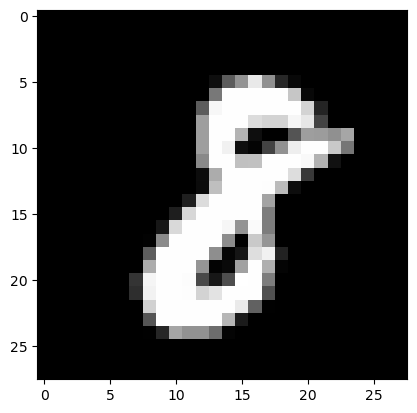

In [40]:
# 첫 번째 이미지만 시각화 합니다.
import matplotlib.pyplot as plt
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

# Conv 레이어

In [41]:
import torch.nn as nn

conv_layer = nn.Conv2d(
    in_channels= 1, # C_in
    out_channels= 5, # C_out
    kernel_size= 3, # H_k, W_k
    padding= 1 # 합성곱 연산을 수행해도 출력 특징맵의 크기가 줄어들지 않도록 처리
)

In [42]:
conv_out = conv_layer(images[:1, ...])
conv_out

tensor([[[[ 0.2211,  0.2211,  0.2211,  ...,  0.2211,  0.2211,  0.2211],
          [ 0.2211,  0.2211,  0.2211,  ...,  0.2211,  0.2211,  0.2211],
          [ 0.2211,  0.2211,  0.2211,  ...,  0.2211,  0.2211,  0.2211],
          ...,
          [ 0.2211,  0.2211,  0.2211,  ...,  0.2211,  0.2211,  0.2211],
          [ 0.2211,  0.2211,  0.2211,  ...,  0.2211,  0.2211,  0.2211],
          [ 0.2211,  0.2211,  0.2211,  ...,  0.2211,  0.2211,  0.2211]],

         [[-0.1017, -0.1017, -0.1017,  ..., -0.1017, -0.1017, -0.1017],
          [-0.1017, -0.1017, -0.1017,  ..., -0.1017, -0.1017, -0.1017],
          [-0.1017, -0.1017, -0.1017,  ..., -0.1017, -0.1017, -0.1017],
          ...,
          [-0.1017, -0.1017, -0.1017,  ..., -0.1017, -0.1017, -0.1017],
          [-0.1017, -0.1017, -0.1017,  ..., -0.1017, -0.1017, -0.1017],
          [-0.1017, -0.1017, -0.1017,  ..., -0.1017, -0.1017, -0.1017]],

         [[ 0.1173,  0.1173,  0.1173,  ...,  0.1173,  0.1173,  0.1173],
          [ 0.1173,  0.1173,  

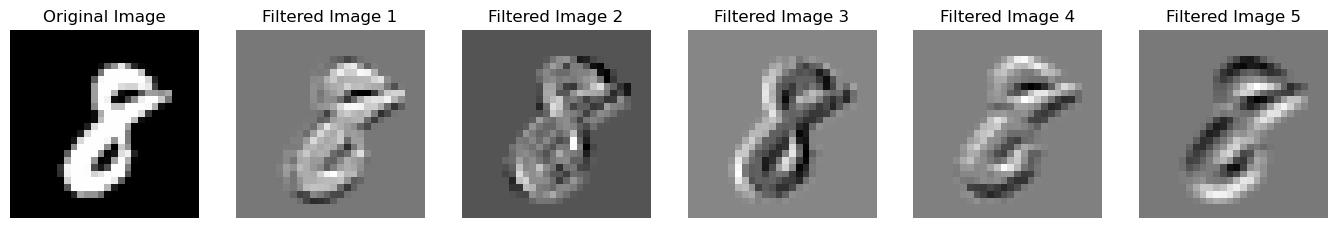

In [43]:
# conv 레이어를 지나간 각 이미지를 시각화 합니다.
conv_out_images = conv_out[0]

fig, axes = plt.subplots(1, 6, figsize=(17, 3))

axes[0].imshow(images[0, ...].squeeze(), cmap='gray')
axes[0].title.set_text('Original Image')
axes[0].axis('off')

for idx, ax in enumerate(axes[1:]):
    ax.imshow(conv_out_images[idx, ...].detach().squeeze(), cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'Filtered Image {idx+1}')
plt.show()

# ReLU 적용 후 시각화

In [44]:
relu_layer = nn.ReLU()
relu_output = relu_layer(conv_out)
relu_output.shape

torch.Size([1, 5, 28, 28])

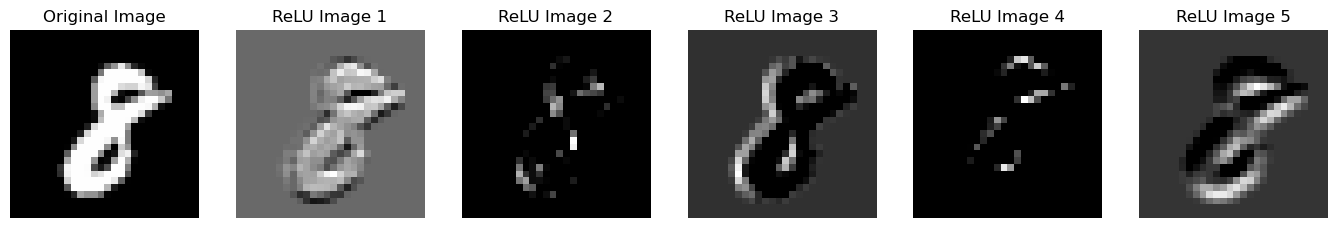

In [45]:
relu_out_images = relu_output[0]

fig, axes = plt.subplots(1, 6, figsize=(17, 3))

axes[0].imshow(images[0, ...].squeeze(), cmap='gray')
axes[0].title.set_text('Original Image')
axes[0].axis('off')

for idx, ax in enumerate(axes[1:]):
    ax.imshow(relu_out_images[idx, ...].detach().squeeze(), cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'ReLU Image {idx+1}')
plt.show()

# MaxPolling 레이어

In [46]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_output = max_pool_layer(relu_output)
max_pool_output.shape

torch.Size([1, 5, 14, 14])

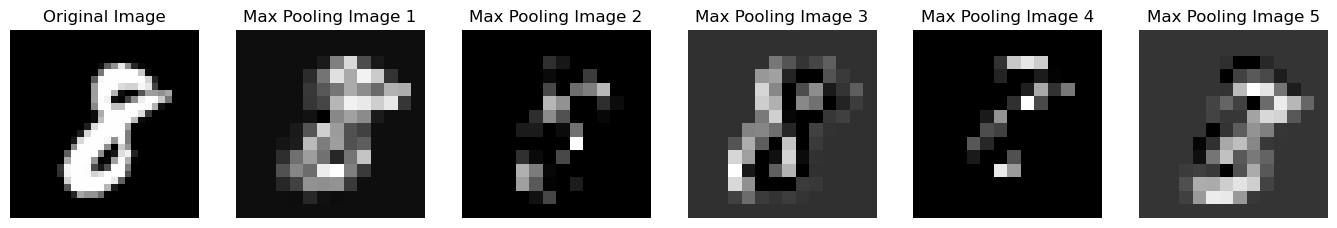

In [47]:
max_pool_out_images = max_pool_output[0]

fig, axes = plt.subplots(1, 6, figsize=(17, 3))

axes[0].imshow(images[0, ...].squeeze(), cmap='gray')
axes[0].title.set_text('Original Image')
axes[0].axis('off')

for idx, ax in enumerate(axes[1:]):
    ax.imshow(max_pool_out_images[idx, ...].detach().squeeze(), cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'Max Pooling Image {idx+1}')
plt.show()

# 지금까지 C-R-P (Feature_extraction)으로 진행

# 평탄화
- 특징 추출이 끝났으면, FCL에 넣어서 공부하는 과정을 구현
- FCL(FCN)은 평탄화된 벡터를 받아서 WX+b 연산을 수행한다.
    - Flatten을 사용하는 방법
    - GAP(Global Average Pooling)을 사용하는 방법 ([논문왈]512개의 채널을 내보낼때 쓰면 좋음)

In [49]:
# Flatten 레이어. 일반적으로 출력 특정 맵의 채널이 512개 미만인 경우 사용하면 좋다.
flatten_layer = nn.Flatten()
flatten_output = flatten_layer(max_pool_output)
flatten_output.shape

torch.Size([1, 980])

In [52]:
# GAP(Global Average Pooling) 레이어. 출력 특징 맵의 채널이 512개 이상인 경우 사용하면 좋다.
gap_layer = nn.AdaptiveAvgPool2d(output_size = 1)
gap_output = gap_layer(max_pool_output)
gap_output = torch.flatten(gap_output, 1)
gap_output.shape

torch.Size([1, 5])

# Linear Layer를 이용한 FCN을 구현
- FCN, FCL -> FCN : Network, FCL : Layer

In [ ]:
# 1층 - 은닉층(입력 : 980개, 출력 256개)
linear_1 = nn.Linear(in_features=980, out_features=256)
linear_1_output = linear_1(flatten_output)
linear_1_output = nn.ReLU()(linear_1_output)
linear_1_output.shape

torch.Size([1, 256])

In [ ]:
# 2층 - 은닉층(입력 : 256개, 출력 128개)
linear_2 = nn.Linear(in_features=256, out_features=128)
linear_2_output = linear_2(linear_1_output)
linear_2_output = nn.ReLU()(linear_2_output)
linear_2_output.shape

torch.Size([1, 128])

In [ ]:
# 3층 - 출력층(입력 : 128개, 출력 10개)
linear_3 = nn.Linear(in_features=128, out_features=10)
linear_3_output = linear_3(linear_2_output)
linear_3_output.shape

torch.Size([1, 10])

# CNN 네트워크 전체 구성하기

In [61]:
class CNN(nn.Module) :

    def __init__(self) :
        super().__init__()

        ###### 첫 번째 블록 ######
        ### C1-1 C1-2 Pooling
        self.conv_1_1 = nn.Conv2d(
            in_channels= 1, # C_in
            out_channels= 32, # C_out
            kernel_size= 3, # H_k, W_k
            padding= 1 # 합성곱 연산을 수행해도 출력 특징맵의 크기가 줄어들지 않도록 처리
        )
        self.relu_1_1 = nn.ReLU()

        self.conv_1_2 = nn.Conv2d(
            in_channels= 32,
            out_channels= 32,
            kernel_size= 3,
            padding= 1
        )
        self.relu_1_2 = nn.ReLU()

        self.max_pool_1 = nn.MaxPool2d(kernel_size=2)
        #########################

        ###### 두 번쨰 블록 ######
        ### C2-1 C2-2 Pooling
        self.conv_2_1 = nn.Conv2d(
            in_channels= 32,
            out_channels= 64, 
            kernel_size= 3, 
            padding= 1 
        )
        self.relu_2_1 = nn.ReLU()

        self.conv_2_2 = nn.Conv2d(
            in_channels= 64,
            out_channels= 64,
            kernel_size= 3,
            padding= 1
        )
        self.relu_2_2 = nn.ReLU()

        self.max_pool_2 = nn.MaxPool2d(kernel_size=2)
        #########################

        ## FCN 구현
        self.flatten = nn.Flatten()

        self.linear_1 = nn.Linear(
            in_features=64*7*7,
            out_features= 256
        )
        self.fcl_1_relu = nn.ReLU()

        self.linear_2 = nn.Linear(
            in_features= 256,
            out_features= 128
        )

        self.fcl_2_relu = nn.ReLU()

        self.linear_3 = nn.Linear(
            in_features=128,
            out_features=10
        )
        ##########################


    def forward(self, x) :
        ## 첫 번쨰 블록 순전파
        x = self.conv_1_1(x)
        x = self.relu_1_1(x)

        x = self.conv_1_2(x)
        x = self.relu_1_2(x)

        x = self.max_pool_1(x)

        ## 두 번쨰 블록 순전파
        x = self.conv_2_1(x)
        x = self.relu_2_1(x)

        x = self.conv_2_2(x)
        x = self.relu_2_2(x)

        x = self.max_pool_2(x) 

        ## FCN 순전파
        x = self.flatten(x)
        
        # 1층
        x = self.linear_1(x)
        x = self.fcl_1_relu(x)

        # 2층
        x = self.linear_2(x)
        x = self.fcl_2_relu(x)

        # 3층 출력층
        y = self.linear_3(x)

        return y

In [62]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [63]:
model = CNN().to(device)
model

CNN(
  (conv_1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU()
  (conv_1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU()
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU()
  (conv_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU()
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=3136, out_features=256, bias=True)
  (fcl_1_relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=128, bias=True)
  (fcl_2_relu): ReLU()
  (linear_3): Linear(in_features=128, out_features=10, bias=True)
)

In [64]:
!pip install torchinfo

In [65]:
from torchinfo import summary

summary(model, input_size = (64, 1, 28, 28), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─Conv2d: 1-3                            [64, 32, 28, 28]          9,248
├─ReLU: 1-4                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-5                         [64, 32, 14, 14]          --
├─Conv2d: 1-6                            [64, 64, 14, 14]          18,496
├─ReLU: 1-7                              [64, 64, 14, 14]          --
├─Conv2d: 1-8                            [64, 64, 14, 14]          36,928
├─ReLU: 1-9                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-10                        [64, 64, 7, 7]            --
├─Flatten: 1-11                          [64, 3136]                --
├─Linear: 1-12                           [64, 256]                 803,07

# 훈련

In [68]:
# CrossEntropyLoss에 이미 소프트맥스 함수가 포함되어 있습니다.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 훈련 루프 정의
def train_loop(dataloader, model, loss_fn, optimizer):

  # 데이터 로더에 있는 데이터 세트의 길이 가져오기
  size = len(dataloader.dataset)
  model.train() # 모델을 훈련 모드로 설정
  for batch, (X, y) in enumerate(dataloader):

    # 데이터 로더에 들어있던 텐서들을 gpu로 옮기기
    X, y = X.to(device), y.to(device)

    # 예측 및 손실 확인
    pred = model(X)
    loss = loss_fn(pred, y)

    # 역전파 수행(미분)
    optimizer.zero_grad() # 기존에 남아있던 gradient 제거( 이전 배치의 기울기를 반영하지 않게 하기 위해)
    loss.backward() # 역전파
    optimizer.step()

    # 배치가 100번 돌 때마다 화면에 출력
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"Train Loss : {loss:>7f} [ {current:>5d} / {size:>5d} ]")

# 추론 루프 정의
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)

  test_loss, correct = 0, 0
  model.eval() # 모델을 추론모드로 설정
  # 추론 과정은 기울기를 구하지 않음
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  num_batches = len(dataloader)

  # 배치 별 loss값의 평균 구하기
  test_loss /= num_batches
  correct /= size

  print(f"Test Error : \n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")

In [69]:
# 학습 수행
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n........................")
  train_loop(train_dl, model, loss_fn, optimizer)
  test_loop(test_dl, model, loss_fn)

print("Done!")

Epoch 1
........................
Train Loss : 0.283041 [     0 / 60000 ]
Train Loss : 0.198140 [  6400 / 60000 ]
Train Loss : 0.187495 [ 12800 / 60000 ]
Train Loss : 0.178958 [ 19200 / 60000 ]
Train Loss : 0.094952 [ 25600 / 60000 ]
Train Loss : 0.103153 [ 32000 / 60000 ]
Train Loss : 0.033314 [ 38400 / 60000 ]
Train Loss : 0.047202 [ 44800 / 60000 ]
Train Loss : 0.062358 [ 51200 / 60000 ]
Train Loss : 0.122474 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 97.8%, Avg Loss : 0.066972

Epoch 2
........................
Train Loss : 0.086789 [     0 / 60000 ]
Train Loss : 0.050405 [  6400 / 60000 ]
Train Loss : 0.024215 [ 12800 / 60000 ]
Train Loss : 0.037934 [ 19200 / 60000 ]
Train Loss : 0.019227 [ 25600 / 60000 ]
Train Loss : 0.016970 [ 32000 / 60000 ]
Train Loss : 0.016537 [ 38400 / 60000 ]
Train Loss : 0.037419 [ 44800 / 60000 ]
Train Loss : 0.101695 [ 51200 / 60000 ]
Train Loss : 0.008985 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 98.4%, Avg Loss : 0.050656

Epoch 3
..................

In [ ]:
class CNN(nn.Module) :

    def __init__(self) :
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels= 32, kernel_size= 3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels= 64, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels= 64, kernel_size= 3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )


    def forward(self, x) :